# AutoRec

- [AutoRec: Autoencoders Meet Collaborative Filtering](http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf)

## Result

- I-AutoRec has higher performance than U-AutoRec
- Optimizer: Adamax
    - Adamax has the highest performance over the other optimizers
    - Adamax > SGD > Adam > RMSprop
- l2 regularization with 0.0001
    - Less strict regularization makes model flexible
- This experiment was conducted using google colab

## Problems

- A sloppy experiment environment
    - Data splitting that makes it difficult to build inference processes in the real world

In [1]:
import glob
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

base_path = 'drive/My Drive/RecSys/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(n_user)

6040


In [5]:
idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(n_item)

3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = Id2idx(ratings)
ratings.head(5)

,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [8]:
def make_interaction(df: pd.DataFrame, user_based = True) -> pd.DataFrame:
    if user_based:
        return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)
    else:
        return df.groupby('movieId', as_index = False)[['userId', 'rating']].agg(list)

In [9]:
def data_split(df: pd.DataFrame):
    train, test = train_test_split(df, test_size = 0.1, random_state = 7777)
    train, test = map(lambda df: df.reset_index(drop = True), (train, test))
    return train, test

In [10]:
def make_generator(df, n_user, n_item, batch_size, user_based = True, implicit = False, threshold = 3.5):
    n_row = df.index.size
    n_col = n_item if user_based else n_user

    Ids = np.arange(n_row)
    profiles = df['movieId'] if user_based else df['userId']
    ratings = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):         
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                batch[i, profiles[idx]] = ratings[idx]
           
            yield batch, batch

In [11]:
def masked_mse(y_true, y_pred, masked_value = 0):
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    return K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true, y_pred, masked_value = 0):
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

def masked_rmse_clip(y_true, y_pred, masked_value = 0):
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    y_pred = K.clip(y_pred, 0, 5)
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

In [12]:
def AutoRec(n_user: int, n_item: int, user_based = True, latent_dim = 500,
            first_activation = 'sigmoid', last_activation = 'linear',
            optimizer = 'nadam', learning_rate = 0.001,
            kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None),
            kernel_regularizer = l2(0.0001)):
    input_shape = n_item if user_based else n_user

    inputs = Input(shape = (input_shape, ), name = 'input')
    latents = Dense(latent_dim, activation = first_activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(inputs)
    outputs = Dense(input_shape, activation = last_activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(latents)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = masked_mse, metrics = masked_rmse)
    return model

## 2. U-AutoRec

In [21]:
epochs = 500
batch_size = 256

user_profile = make_interaction(ratings, user_based = True)
train, test = data_split(user_profile)
train_gen, test_gen = map(lambda x: make_generator(x, n_user, n_item, batch_size, user_based = True), (train, test))

steps_per_epoch = train.userId.unique().size // batch_size + 1
validation_steps = test.userId.unique().size // batch_size + 1

In [22]:
# lr_schedule = ExponentialDecay(initial_learning_rate = 0.002, decay_steps = 10, decay_rate = 0.96, staircase = True)
# optimizer = RMSprop(learning_rate = lr_schedule)
# optimizer = SGD(lr = 0.1, decay = 1e-5, momentum = 0.9, nesterov = True)
model = AutoRec(n_user, n_item, optimizer = 'adamax')
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 500)               1853500   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1856706   
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint(base_path + 'model/U-AutoRec_1M.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = test_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
22/22 [==============================] - 1s 54ms/step - loss: 6.1846 - masked_rmse: 2.1090 - val_loss: 2.4493 - val_masked_rmse: 1.2285
Epoch 2/500
22/22 [==============================] - 1s 49ms/step - loss: 2.1793 - masked_rmse: 1.1235 - val_loss: 1.9504 - val_masked_rmse: 1.0355
Epoch 3/500
22/22 [==============================] - 1s 50ms/step - loss: 1.9191 - masked_rmse: 1.0248 - val_loss: 1.8780 - val_masked_rmse: 1.0125
Epoch 4/500
22/22 [==============================] - 1s 50ms/step - loss: 1.8303 - masked_rmse: 0.9945 - val_loss: 1.8363 - val_masked_rmse: 1.0035
Epoch 5/500
22/22 [==============================] - 1s 48ms/step - loss: 1.7730 - masked_rmse: 0.9784 - val_loss: 1.7794 - val_masked_rmse: 0.9866
Epoch 6/500
22/22 [==============================] - 1s 48ms/step - loss: 1.7276 - masked_rmse: 0.9666 - val_loss: 1.7553 - val_masked_rmse: 0.9842
Epoch 7/500
22/22 [==============================] - 1s 48ms/step - loss: 1.6889 - masked_rmse: 0.9570 - val_los

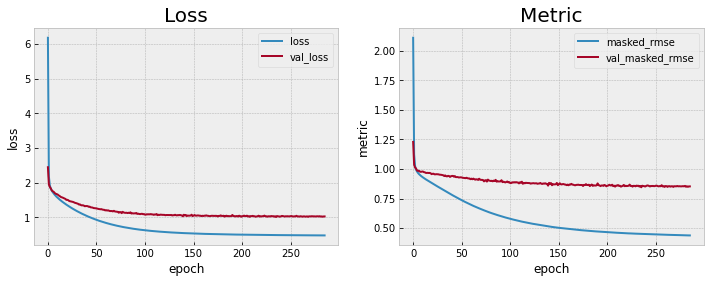

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss', fontsize = 20)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['loss', 'val_loss'], loc = 'upper right')

ax2.plot(hist.history['masked_rmse'])
ax2.plot(hist.history['val_masked_rmse'])
ax2.set_title('Metric', fontsize = 20)
ax2.set_ylabel('metric')
ax2.set_xlabel('epoch')
ax2.legend(['masked_rmse', 'val_masked_rmse'], loc = 'upper right')

plt.show()

## 3. I-AutoRec

In [25]:
epochs = 500
batch_size = 256

item_profile = make_interaction(ratings, user_based = False)
train, test = data_split(item_profile)
train_gen, test_gen = map(lambda x: make_generator(x, n_user, n_item, batch_size, user_based = False), (train, test))

steps_per_epoch = train.movieId.unique().size // batch_size + 1
validation_steps = test.movieId.unique().size // batch_size + 1

In [26]:
model = AutoRec(n_user, n_item, optimizer = 'adamax', user_based = False)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6040)]            0         
_________________________________________________________________
encoder (Dense)              (None, 500)               3020500   
_________________________________________________________________
decoder (Dense)              (None, 6040)              3026040   
Total params: 6,046,540
Trainable params: 6,046,540
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint(base_path + 'model/I-AutoRec_1M.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = test_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
14/14 [==============================] - 1s 67ms/step - loss: 7.8371 - masked_rmse: 2.3846 - val_loss: 3.7717 - val_masked_rmse: 1.4778
Epoch 2/500
14/14 [==============================] - 1s 57ms/step - loss: 3.3631 - masked_rmse: 1.3285 - val_loss: 2.9797 - val_masked_rmse: 1.2085
Epoch 3/500
14/14 [==============================] - 1s 57ms/step - loss: 2.8044 - masked_rmse: 1.1285 - val_loss: 2.6803 - val_masked_rmse: 1.1033
Epoch 4/500
14/14 [==============================] - 1s 55ms/step - loss: 2.5874 - masked_rmse: 1.0525 - val_loss: 2.5446 - val_masked_rmse: 1.0590
Epoch 5/500
14/14 [==============================] - 1s 60ms/step - loss: 2.4638 - masked_rmse: 1.0128 - val_loss: 2.4802 - val_masked_rmse: 1.0410
Epoch 6/500
14/14 [==============================] - 1s 54ms/step - loss: 2.3746 - masked_rmse: 0.9868 - val_loss: 2.4122 - val_masked_rmse: 1.0225
Epoch 7/500
14/14 [==============================] - 1s 57ms/step - loss: 2.3009 - masked_rmse: 0.9664 - val_los

In [38]:
RMSE = min(hist.history['val_masked_rmse'])
print(f'test RMSE: {RMSE:.3f}')

test RMSE: 0.822


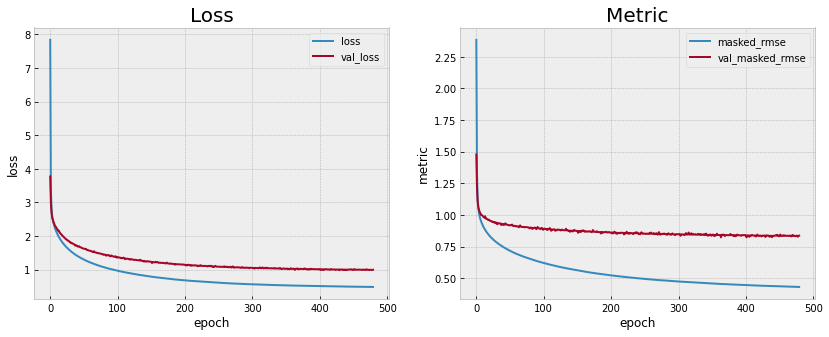

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss', fontsize = 20)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['loss', 'val_loss'], loc = 'upper right')

ax2.plot(hist.history['masked_rmse'])
ax2.plot(hist.history['val_masked_rmse'])
ax2.set_title('Metric', fontsize = 20)
ax2.set_ylabel('metric')
ax2.set_xlabel('epoch')
ax2.legend(['masked_rmse', 'val_masked_rmse'], loc = 'upper right')

plt.show()